# Part 2: Time Series Modeling

In this notebook, you will implement functions to extract features from time series data and build ARIMA models.

In [2]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from pathlib import Path
import os

# Set style for plots
plt.style.use('seaborn-v0_8')
%matplotlib inline

## 1. Feature Extraction

Implement the `extract_time_series_features` function to calculate rolling window features.

In [ ]:
def extract_time_series_features(data, window_size=60):
    """Extract rolling window features from time series data.
    
    Parameters
    ----------
    data : pd.DataFrame
        Preprocessed physiological data
    window_size : int
        Size of the rolling window in seconds
        
    Returns
    -------
    pd.DataFrame
        DataFrame containing extracted features for each signal
    """
    # Your code here
    # 1. Calculate rolling window statistics
    # 2. Include mean, std, min, max, and autocorrelation

    # make sure datetime is properly index
    data = data.copy()
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    data = data.set_index('timestamp').sort_index()
    
    # signals to process
    signals = ['heart_rate', 'eda', 'temperature']
    signals = [s for s in signals if s in data.columns]
    
    # feature dictionary
    feature_dict = {}
    
    # autocorrelation function
    def autocorr(x, lag=1):
        return x.autocorr(lag=lag) if len(x) > lag else np.nan
    
    # loop thru each signal
    for signal in signals:
        # rolling window object
        roller = data[signal].rolling(f'{window_size}s', min_periods=5)
        
        # calc features
        feature_dict.update({
            f'{signal}_mean': roller.mean(),
            f'{signal}_std': roller.std(),
            f'{signal}_min': roller.min(),
            f'{signal}_max': roller.max(),
            f'{signal}_range': roller.max() - roller.min(),
            f'{signal}_autocorr_lag1': roller.apply(autocorr, raw=False)
        })
    
    # combine features
    feature_df = pd.DataFrame(feature_dict)
    
    # reset index and drop rows where all NA
    feature_df = (
        feature_df
        .dropna(how='all') 
        .reset_index()
    )
    
    return feature_df

In [5]:
df_clean = pd.read_csv('data/processed/S1_processed.csv')
features_df = extract_time_series_features(df_clean, window_size=60)
features_df

,timestamp,heart_rate_mean,heart_rate_std,heart_rate_min,heart_rate_max,heart_rate_range,heart_rate_autocorr_lag1,eda_mean,eda_std,eda_min,eda_max,eda_range,eda_autocorr_lag1,temperature_mean,temperature_std,temperature_min,temperature_max,temperature_range,temperature_autocorr_lag1
0,2018-10-13 12:56:10+00:00,NaN,NaN,NaN,NaN,NaN,NaN,0.020631,0.005458,0.010892,0.023386,0.012494,-0.049955,22.506000,0.008944,22.49,22.51,0.02,NaN
1,2018-10-13 12:56:11+00:00,NaN,NaN,NaN,NaN,NaN,NaN,0.021036,0.004982,0.010892,0.023386,0.012494,-0.047845,22.510000,0.012649,22.49,22.53,0.04,-7.905694e-01
2,2018-10-13 12:56:12+00:00,NaN,NaN,NaN,NaN,NaN,NaN,0.021280,0.004594,0.010892,0.023386,0.012494,-0.113595,22.512857,0.013801,22.49,22.53,0.04,-6.222668e-14
3,2018-10-13 12:56:13+00:00,NaN,NaN,NaN,NaN,NaN,NaN,0.021584,0.004338,0.010892,0.023706,0.012814,-0.003646,22.515000,0.014142,22.49,22.53,0.04,2.282177e-01
4,2018-10-13 12:56:14+00:00,NaN,NaN,NaN,NaN,NaN,NaN,0.021713,0.004077,0.010892,0.023706,0.012814,-0.064391,22.514444,0.013333,22.49,22.53,0.04,1.428571e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45696,2018-12-05 22:58:49+00:00,130.779833,3.182419,123.15,134.55,11.40,0.970923,0.026193,0.000522,0.024666,0.027869,0.003204,-0.086938,24.897333,1.176879,24.21,30.11,5.90,7.723194e-01
45697,2018-12-05 22:58:50+00:00,130.636167,3.346579,122.73,134.55,11.82,0.973907,0.026203,0.000530,0.024666,0.027869,0.003204,-0.065847,24.937000,1.196689,24.21,30.11,5.90,7.801478e-01
45698,2018-12-05 22:58:51+00:00,130.480667,3.507771,122.40,134.55,12.15,0.976583,0.026214,0.000525,0.024666,0.027869,0.003204,-0.072939,24.976333,1.214385,24.21,30.11,5.90,7.868032e-01
45699,2018-12-05 22:58:52+00:00,130.307833,3.667447,121.95,134.55,12.60,0.979202,0.027340,0.008705,0.024666,0.093525,0.068860,0.006930,25.015667,1.230550,24.21,30.11,5.90,7.925546e-01


## 2. ARIMA Modeling

Implement the `build_arima_model` function to fit ARIMA models and generate diagnostic plots.

In [8]:
def build_arima_model(series, order=(1,1,1), output_dir='plots'):
    """Fit an ARIMA model to the time series and generate diagnostic plots.
    
    Parameters
    ----------
    series : pd.Series
        Time series data to model
    order : tuple
        (p,d,q) order of the ARIMA model
    output_dir : str
        Directory to save diagnostic plots
        
    Returns
    -------
    statsmodels.tsa.arima.model.ARIMAResults
        Fitted ARIMA model
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Your code here
    # 1. Fit ARIMA model
    model = ARIMA(series, order=order)
    model_fit = model.fit()

    # 2. Generate diagnostic plots:
    fig, axes = plt.subplots(3, 1, figsize=(12, 10))
    #    - Model fit plot
    axes[0].plot(series, label='Original')
    axes[0].plot(model_fit.fittedvalues, label='Fitted', alpha=0.7)
    axes[0].set_title('ARIMA Model Fit')
    axes[0].legend()

    #    - Residuals plot
    residuals = model_fit.resid
    axes[1].plot(residuals)
    axes[1].set_title('Residuals')

    #    - Forecast plot
    forecast = model_fit.forecast(steps=30)
    axes[2].plot(series, label='Original')
    forecast_index = pd.date_range(start=series.index[-1], periods=30, freq='s')
    axes[2].plot(forecast_index, forecast, label='Forecast', linestyle='--')
    axes[2].set_title('Forecast')
    axes[2].legend()

    # 3. Save plots to output directory
    plt.tight_layout()
    plot_path = os.path.join(output_dir, f'arima_diagnostics_{series.name or "series"}.png')
    plt.savefig(plot_path)
    return model_fit
    pass

/Users/michelle/Documents/DATASCI 223/4-it-s-about-time-muhchellee/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ns will be used.
  self._init_dates(dates, freq)
/Users/michelle/Documents/DATASCI 223/4-it-s-about-time-muhchellee/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ns will be used.
  self._init_dates(dates, freq)
/Users/michelle/Documents/DATASCI 223/4-it-s-about-time-muhchellee/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ns will be used.
  self._init_dates(dates, freq)


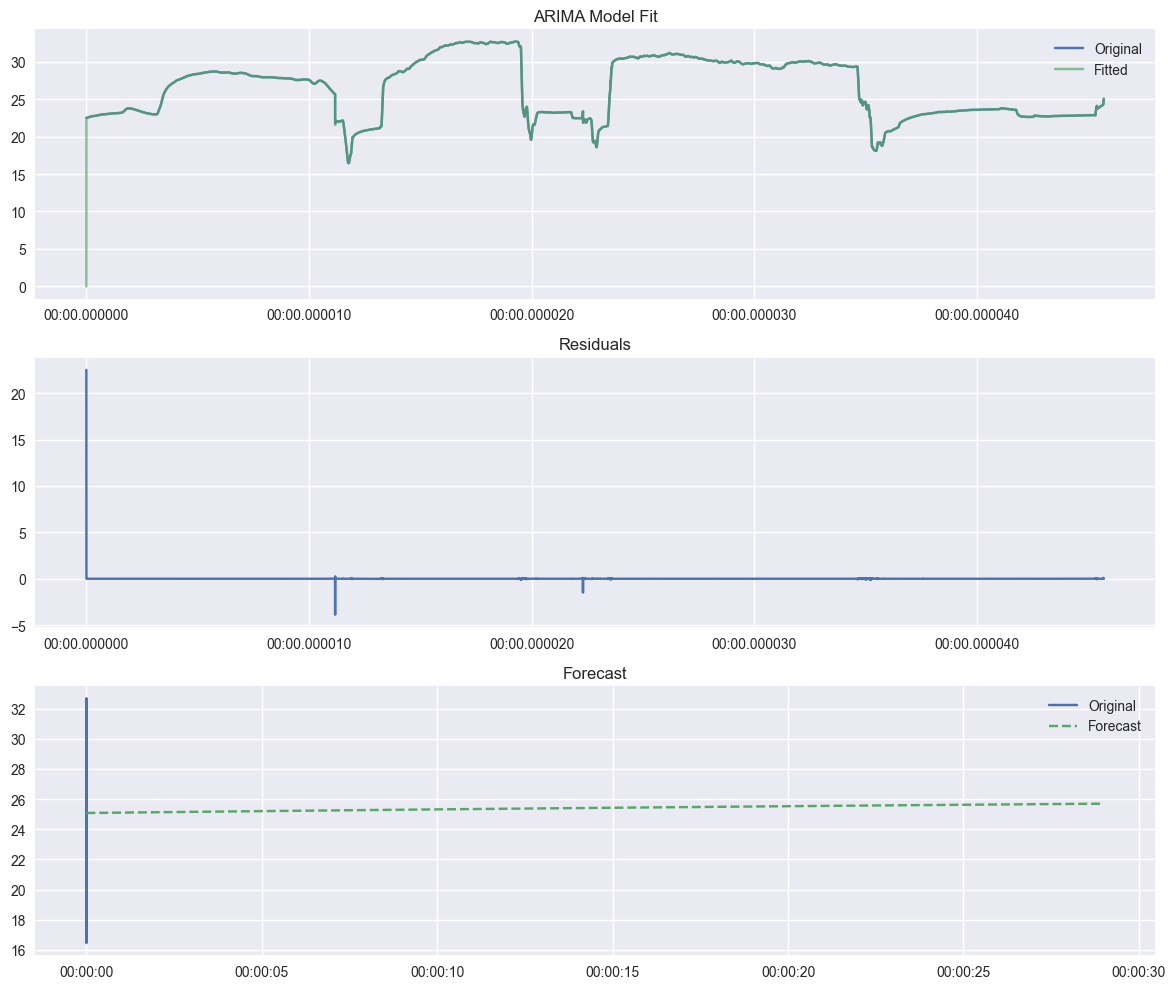

In [ ]:
series = features_df['eda_mean'].copy()
series.index = pd.to_datetime(series.index)
build_arima_model(series, order=(1,1,1), output_dir='plots')